<a href="https://colab.research.google.com/github/PedroHenriqueS22/Praticas_Analise_Dados_DNC/blob/main/Marketing_AutoML_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Regressão para marketing

## Contexto

Uma empresa está investindo mensalmente em plataformas de publicidade online, como Youtube, Facebook e newspaper, para a prospecção de leads (pessoas interessadas em seus produtos). A fim de acompanhar o desempenho desses investimentos, a empresa registra todos os gastos com publicidade e todos os retornos de vendas gerados a partir desses investimentos. Para entender melhor a relação entre as variáveis presentes nesses registros e identificar os atores que mais impactam na geração de leads, a empresa solicitou a análise de um especialista em dados. Além disso, a empresa busca criar um modelo de predição de valores para estimar o retorno de vendas que pode ser gerado a partir de um determinado investimento em publicidade.

## Sobre os dados

A tabela contém informações dos investimentos feitos pelo youtube, facebook,
newspaper e o valor das vendas.

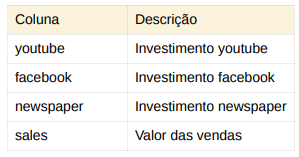

## Etapas

* Análise Descritiva
* Análise Exploratória
* Modelagem
* Calculando predição



---

Instalação do Auto-Sklearn:

* Em um primeiro momento não foi possível fazer a instalação do Auto-Sklearn. A seguir se encontra os passos os quais encontrei para solucionar esse problema.

[Link onde foi encontrado a solução.](https://github.com/automl/auto-sklearn/issues/1684)




In [ ]:
!pip install Cython==0.29.36
!pip uninstall scipy -y
!pip install scipy==1.9
!pip uninstall pyparsing -y
!pip install pyparsing==2.4
!pip uninstall scikit_learn -y

In [ ]:
!pip uninstall imbalanced-learn -y
!pip uninstall mlxtend -y
!pip uninstall yellowbrick -y

In [ ]:
!pip install scikit-learn==0.24.2 --no-build-isolation

In [ ]:
!pip install auto-sklearn

In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import autosklearn.regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Importando o arquivo com os dados

In [ ]:
upload = files.upload()

Saving MKT.csv to MKT.csv


In [ ]:
# DataFrame

df = pd.read_csv("MKT.csv", sep=",")
df = pd.DataFrame(df)

# 1. Análise Descritiva

In [ ]:
# Visualizando as primeiras 5 linhas da base de dados

df.head()

,youtube,facebook,newspaper,sales
0,84.72,19.20,48.96,12.60
1,351.48,33.96,51.84,25.68
2,135.48,20.88,46.32,14.28
3,116.64,1.80,36.00,11.52
4,318.72,24.00,0.36,20.88


In [ ]:
# Criando a feature de investimento total

df["Total_Investment"] = df["youtube"] + df["facebook"] + df["newspaper"]
df.head()

,youtube,facebook,newspaper,sales,Total_Investment
0,84.72,19.20,48.96,12.60,152.88
1,351.48,33.96,51.84,25.68,437.28
2,135.48,20.88,46.32,14.28,202.68
3,116.64,1.80,36.00,11.52,154.44
4,318.72,24.00,0.36,20.88,343.08


In [ ]:
# Verificando dados nulos e os tipos de variáveis presentes na base de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   youtube           171 non-null    float64
 1   facebook          171 non-null    float64
 2   newspaper         171 non-null    float64
 3   sales             171 non-null    float64
 4   Total_Investment  171 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


* Verifica-se que todas as entradas são não-nulas e os Dtypes estão como esperado.


In [ ]:
# Gerando as estatísticas descritivas dos dados

df.describe()

,youtube,facebook,newspaper,sales,Total_Investment
count,171.000000,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807,240.932632
std,102.449597,17.913532,24.902918,6.314608,112.167551
min,0.840000,0.000000,0.360000,1.920000,25.680000
25%,91.080000,11.700000,13.740000,12.540000,146.820000
50%,179.760000,26.760000,31.080000,15.480000,248.400000
75%,262.980000,43.680000,50.880000,20.820000,337.740000
max,355.680000,59.520000,121.080000,32.400000,520.320000


* Observa-se que o investimento médio do Youtube é bem superior ao demais;
* Ao analisar as estatísticas descritivas dos dados percebe-se que o desvio padrão de todas as plataformas estão abaixo de suas respectivas médias, ou seja, não temos tanta diferenciação entre valores;
* Apesar do apresentado acima, pode-se ver que o Youtube apresenta uma maior dispersão dos dados em comparação ao Facebook e Newspaper.




# 2. Análise Exploratória

In [ ]:
# Plotando o gráfico para analisar a distribuição de investimentos por plataforma

fig = px.box(df[['youtube', 'facebook', 'newspaper']])
fig.update_traces(line_color='#006D9C')

* Com a utilização do boxplot acima podemos identificar um outlier (121.08) nos investimento do Newspaper, a priori foi decidido deixar o outlier;
* Pontos extremos podem conter informações valiosas sobre falhas, incidentes e fraudes. Sendo assim, vale investigar a natureza desse investimento discrepante.



In [ ]:
# Cálculando a média de investimento por plataforma

df_mean = round(df[['youtube', 'facebook', 'newspaper']].mean().reset_index(), 2)
df_mean.rename(columns={'index':'Platform', 0:'Avg_investment'}, inplace=True)
df_mean

,Platform,Avg_investment
0,youtube,178.02
1,facebook,27.67
2,newspaper,35.24


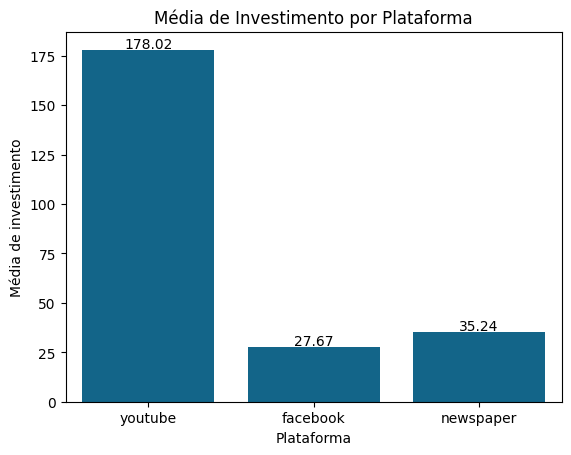

In [ ]:
# Plotando o gráfico para visualizar a média de investimento por plataforma

ax = sns.barplot(data=df_mean, x="Platform", y="Avg_investment", color = "#006D9C");
ax.set(xlabel = "Plataforma", ylabel = "Média de investimento");
ax.set_title("Média de Investimento por Plataforma")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4),
                textcoords='offset points')

In [ ]:
# Cálculando o total investido por plataforma

df_invest = round(df[['youtube', 'facebook', 'newspaper']].sum().reset_index(), 2)
df_invest.rename(columns={'index':'Platform', 0:'Total_Investment'}, inplace=True)
df_invest = df_invest.sort_values(by="Total_Investment", ascending=False)
df_invest


,Platform,Total_Investment
0,youtube,30441.60
2,newspaper,6026.04
1,facebook,4731.84


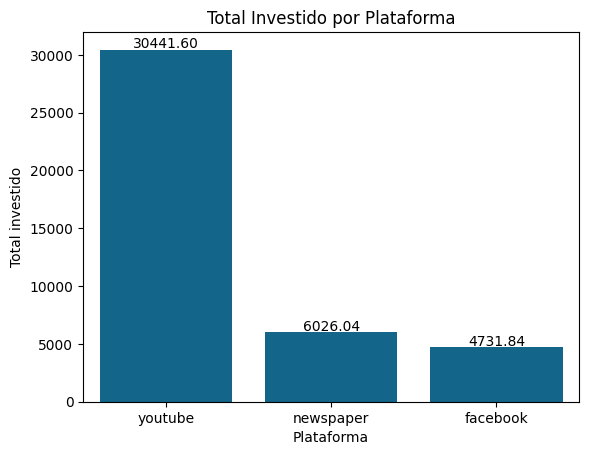

In [ ]:
# Plotando o gráfico para visualizar o total investido por plataforma

ax = sns.barplot(data=df_invest, x="Platform", y="Total_Investment", color = "#006D9C");
ax.set(xlabel = "Plataforma", ylabel = "Total investido");
ax.set_title("Total Investido por Plataforma")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4),
                textcoords='offset points')

*   Nota-se, a partir do valor total investido e a média investida em cada plataforma, que a plataforma a qual se tem maior foco de investimento é o Youtube, o qual tem um valor investido bem superior aos demais, como já tinhamos percebido no describe.




In [ ]:
# Verificando a correlação dos dados presentes na base de dados

df.corr()

,youtube,facebook,newspaper,sales,Total_Investment
youtube,1.000000,0.086538,0.110759,0.782030,0.951773
facebook,0.086538,1.000000,0.293425,0.602918,0.303889
newspaper,0.110759,0.293425,1.000000,0.254987,0.370040
sales,0.782030,0.602918,0.254987,1.000000,0.867176
Total_Investment,0.951773,0.303889,0.370040,0.867176,1.000000


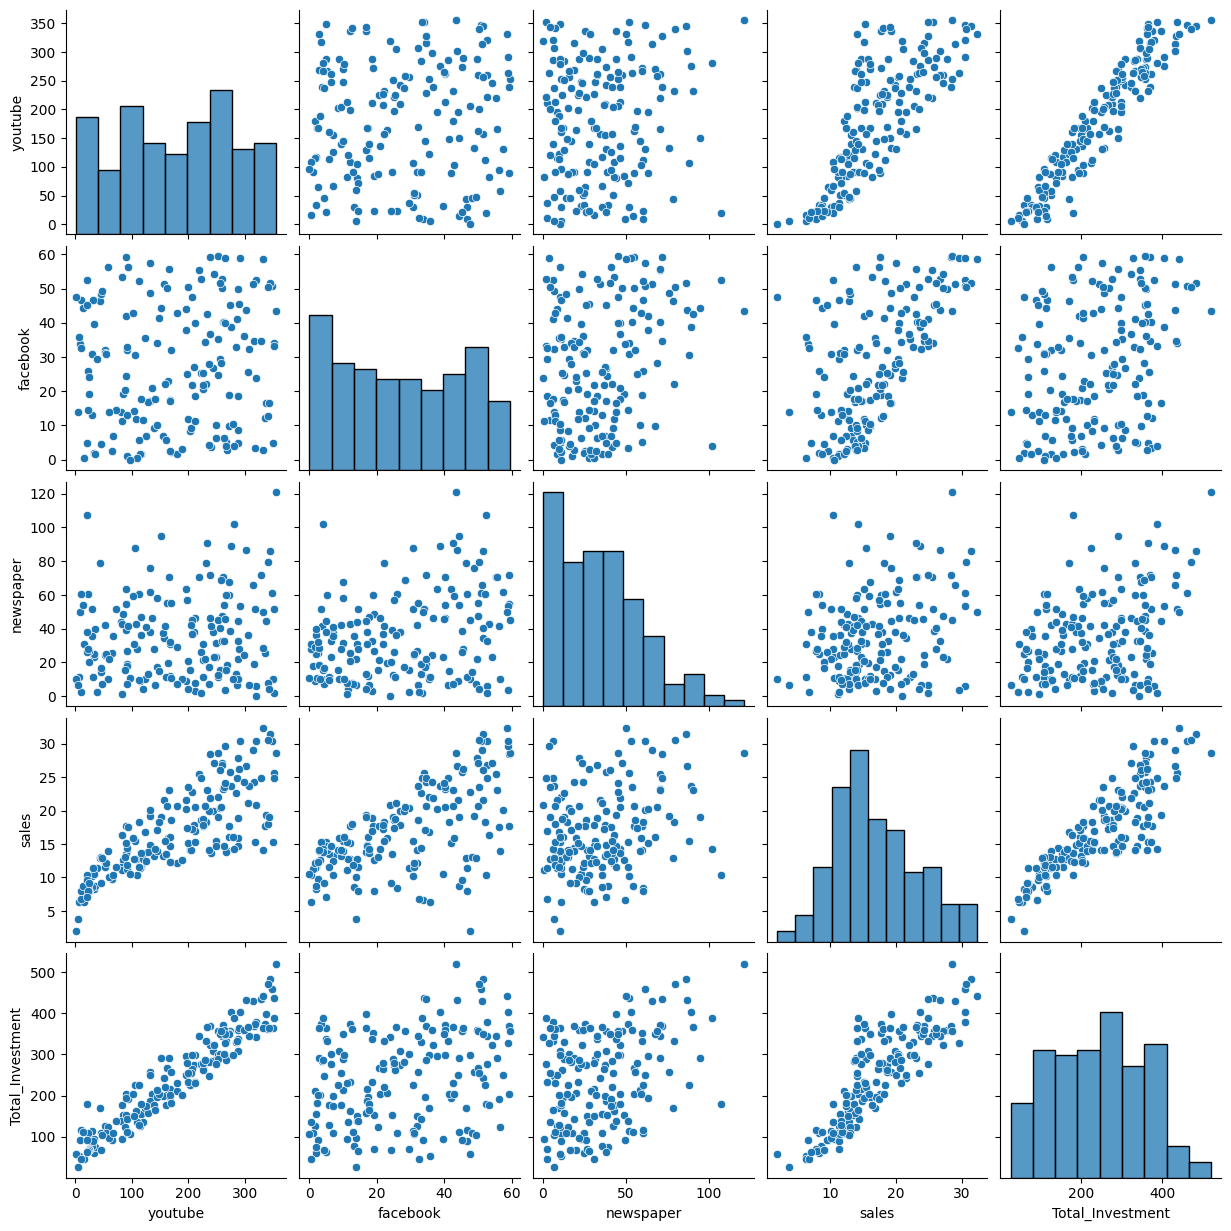

In [ ]:
# Verificando a correlação dos dados presentes na base de dados por meio de gráficos

sns.pairplot(df);

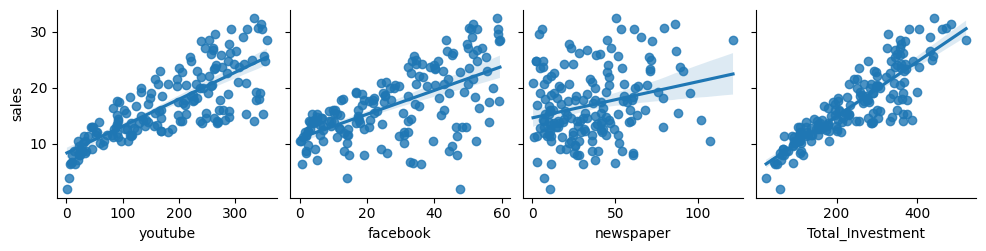

In [ ]:
# Verificando a correlação das vendas com o investimento por plataforma

sns.pairplot(df, x_vars=['youtube', 'facebook', 'newspaper', 'Total_Investment'], y_vars='sales', kind='reg', palette="#006D9C")

<Axes: >

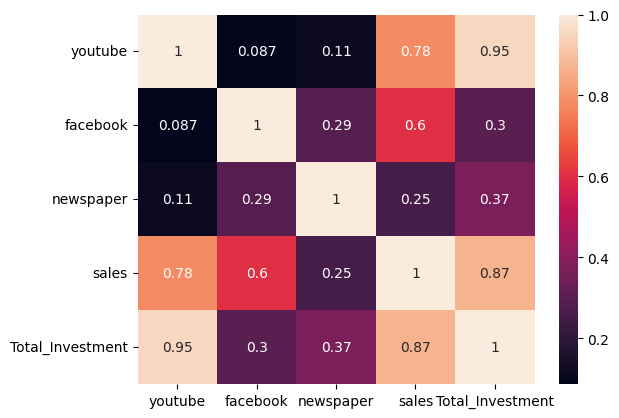

In [ ]:
# Verificando a correlação dos dados presentes na base de dados por meio de mapa de calor

sns.heatmap(df.corr(), annot=True)

* É possível perceber uma correlação entre o investimento e as vendas;
* Ao observar a correlação entre os dados da tabela, tanto de forma visual quanto numérica, nota-se que os investimentos, quando aplicados ao Youtube e Facebook, tendem a ter um bom retorno com relação as vendas, porém com relação ao Newspaper não temos essa tendência, visto que a correlação mostra um impacto bem inferior nas vendas.




# 3. Modelagem

In [ ]:
# Verificando o nome das colunas

df.columns

Index(['youtube', 'facebook', 'newspaper', 'sales', 'Total_Investment'], dtype='object')

In [ ]:
# Atribuindo as variáveis de treino e variáveis de teste

X = df[['youtube', 'facebook', 'newspaper']]

y = df[['sales']]

In [ ]:
# Separação de Train/Test dataset padrão com 30% de massa para teste via método Sklearn.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [ ]:
# Verificando as váriaveis

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119, 3)
(52, 3)
(119, 1)
(52, 1)


# 3.1 Regressão linear

In [ ]:
# Criando variável com o modelo de regressão linear e passando a massa de treino para o modelo

RegLinear = LinearRegression().fit(X_train,y_train)

In [ ]:
# Treinando modelos com a massa de teste

yPredLinear = RegLinear.predict(X_test) # Fazendo a predição com a massa de teste

# 3.2 AutoML (Automated Machine Learning)

In [ ]:
# Criando variável com as configurações desejadas, para ser testada com vários modelos e nos "dizer" qual o melhor modelo

AutoML = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=240, per_run_time_limit = 60,metric= autosklearn.metrics.mean_squared_error)

In [ ]:
# Treinando modelos com a massa de teste

AutoML_Train = AutoML.fit(X_train, y_train)

In [ ]:
# Verificando quais modelos foram executados

AutoML_Train.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
42,1,0.86,gaussian_process,0.281816,0.917074
7,2,0.08,gradient_boosting,0.412023,1.424888
35,3,0.02,ard_regression,3.578821,0.797354
56,4,0.02,ard_regression,9.920525,1.251222
66,5,0.02,liblinear_svr,10.054392,0.756797


* O modelo que obteve um melhor resultado foi o do Processo Gaussiano.



In [ ]:
# Testando o modelo número 1 do rank

yAutoML= AutoML_Train.predict(X_test)

* Na modelagem foi escolhido, em um primeiro momento, fazer pela Regressão Linear e posteriormente foi decidido testar pelo uso da técnica de AutoML para ver qual modelo se comportava melhor.



# 4.0 Predição

## Cálculo do coeficiente de determinação



In [ ]:
r2_LR = r2_score(y_test, yPredLinear)
r2_GR = r2_score(y_test, yAutoML)
print(f'R² do modelo de Regressão Linear = {r2_LR}')
print(f'R² do modelo Regressão Gaussiana= {r2_GR}')

R² do modelo de Regressão Linear = 0.882423505618885
R² do modelo Regressão Gaussiana= 0.981504770947721


* Percebe-se que o R2 do modelo de Regressão Gaussiana a partir da técnica de AutoML é superior ao do modelo de Regressão Linear.



## Cálculo do MSE e RMSE

In [ ]:
MSE_LR = mean_squared_error(y_test, yPredLinear)
MSE_GR = mean_squared_error(y_test, yAutoML)

print(f'MSE do modelo Regressão Linear: {MSE_LR:f}')
print(f'RMSE LR: {np.sqrt(MSE_LR):f}')
print()
print(f'MSE do modelo Regressão Gaussiana: {MSE_GR:f}')
print(f'RMSE GR: {np.sqrt(MSE_GR):f}')

MSE do modelo Regressão Linear: 4.699446
RMSE LR: 2.167820

MSE do modelo Regressão Gaussiana: 0.739241
RMSE GR: 0.859791


* Percebe-se que o MSE e RMSE do modelo de Regressão Gaussiana apresentou um resultado melhor, o qual quanto menor o valor mais acertivo é o modelo.



## Gráficos de comparação do valor real com a predição

* Nos gráficos abaixo fica visível como o modelo Gaussiano encontrado com a técnia de AutoML se comporta melhor.


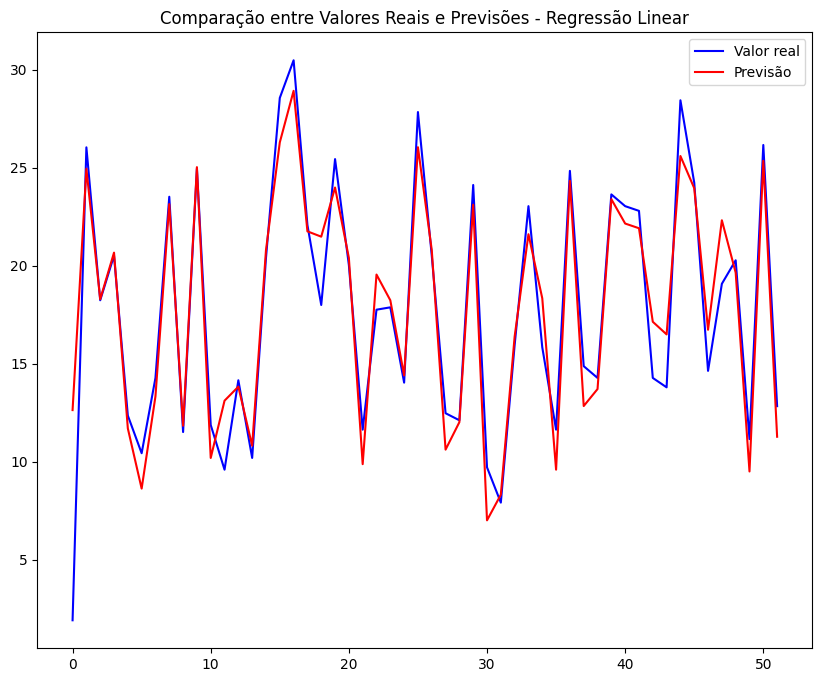

In [ ]:
# Comparando visualmente os valores reais(y_test) com os valores da previsão(yPredLinear)

c = [i for i in range(0, len(yPredLinear), 1)]
fig = plt.figure(figsize=(10,8))
plt.plot(c, y_test, color="blue", label='Valor real')
plt.plot(c, yPredLinear, color = "red", label='Previsão')
plt.title('Comparação entre Valores Reais e Previsões - Regressão Linear')
plt.legend()

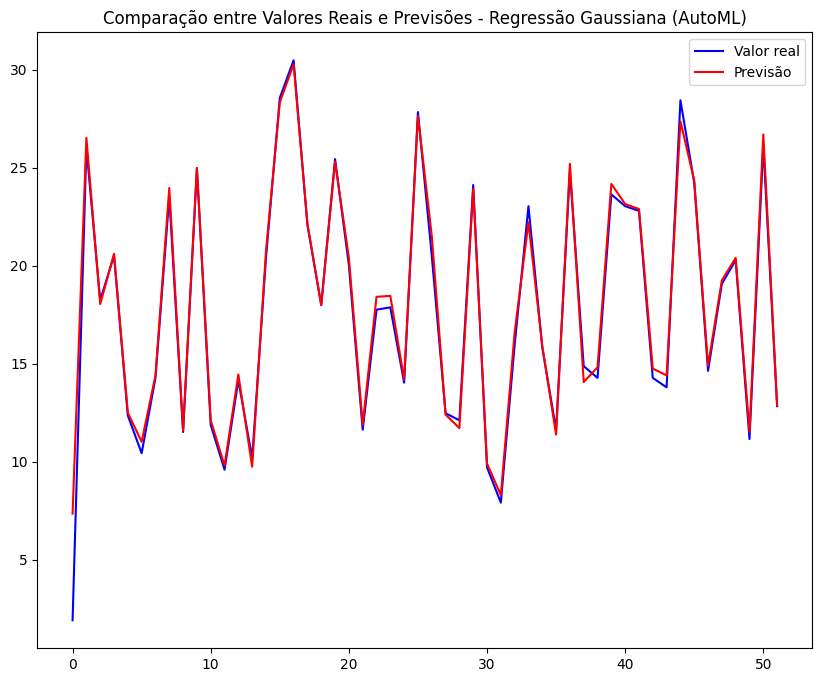

In [ ]:
# Comparando visualmente os valores reais(Y_test) com os valores da previsão(yAutoML)

c = [i for i in range(0, len(yAutoML), 1)]
fig = plt.figure(figsize=(10,8))
plt.plot(c, y_test, color="blue", label='Valor real')
plt.plot(c, yAutoML, color = "red", label='Previsão')
plt.title('Comparação entre Valores Reais e Previsões - Regressão Gaussiana (AutoML)')
plt.legend()

## Predição do modelo de Regressão Linear

In [ ]:
youtube = 84.72
facebook = 19.20
newspaper = 48.96

entrada = [[youtube,facebook,newspaper]]


print(f'Predição do modelo de Regressão Linear: ')
RegLinear.predict(entrada)[0]

Predição do modelo de Regressão Linear: 


array([11.10107426])

## Predição do modelo de Regressão Gaussiana a partir do AutoML

In [ ]:
youtube = 84.72
facebook = 19.20
newspaper = 48.96

entrada = pd.DataFrame([[youtube, facebook, newspaper]], columns=X_train.columns)
predicao_GR = AutoML_Train.predict(entrada)[0]

print(f'Predição do modelo de Regressão Gaussiana = {predicao_GR:.2f}')

Predição do modelo de Regressão Gaussiana = 12.53


* Para fins de outra forma de visualização de qual modelo ficou melhor foi feito uma predição para cada modelo usando os valores investidos no Youtube, Facebook e Newspaper da primeira linha do nosso DataFrame. O valor mostrado na coluna de Sales para essa linha foi de 12.60, no modelo de Regressão Linear tivemos uma diferença de 1.5, já para o modelo de Regressão Gaussiana foi de 0.07. Portanto, tanto pelos cálculos do R2, MSE e RMSE, como pelo exemplo de predição, podemos conluir que o modelo de Regressão Gaussiana é melhor.



## Predição com valores de investimentos ficticios para simular uma predição das vendas de acordo com o investimento.

* Foi escolhido o modelo Gaussiano.




In [ ]:
youtube = 200
facebook = 75
newspaper = 25

entrada = pd.DataFrame([[youtube, facebook, newspaper]], columns=X_train.columns)
predicao_GR = AutoML_Train.predict(entrada)[0]

print(f'Predição do modelo de Regressão Gaussiana = {predicao_GR:.2f}')

Predição do modelo de Regressão Gaussiana = 27.42


# Conclusão

A partir do estudo realizado foi possível verificar que o investimento tem um impacto no valor de vendas, sendo o Youtube e Facebook as plataformas as quais se tem um melhor retorno. Além disso foi criado um modelo de predição de valores para estimar o retorno de vendas de acordo com o investimento feito nas plataformas. Para encontrar o melhor modelo foi testado, em um primeiro momento, o modelo de Regressão Linear e depois foi feito uso da técnica de AutoML, a qual permite a seleção e otimização automática de modelos de Machine Learning. Com o uso da técnica de AutoML, cálculo do R2, do MSE e RMSE ficou comprovado que o melhor modelo de predição foi o modelo Gaussiano.
